In [57]:
import numpy as np
import mne
from glob import glob
import pandas as pd
import pylab as plt

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')

In [58]:
# Grab the full set of subjects and sessions to use
root = 'D:/'  # root directory for saved data
master = pd.read_csv(root+'master.csv')
sub_list = master['subject'].unique()

In [59]:
from mne.time_frequency import psd_multitaper
from scipy.stats import ttest_ind
from codebase import get_window_power_epo, remove_bad_epochs

import warnings
warnings.filterwarnings("ignore")  # using this for a really dumb deprecation warning, nothing dangerous is happening

res = pd.DataFrame() # for storing our outputs

# Set some params
freqs = [3, 8]
start_time = 0.05 # in seconds
win_size = 0.5 # in seconds
subtract_baseline = True
baseline_start = -0.5; baseline_end = -0.05 # for subtracting off baseline power

for sub in sub_list[:]:
    #Load the data
    try:
        dirs = glob(root+str(sub)+'/*/')        
        fname = root+str(sub)+'/complete_epo.fif'
        epochs = mne.read_epochs(fname, preload=True, verbose=False)

        # If contacts differ between sessions (sometimes due to bad_channels), then will need to load multiple contacts.pkl
        # Efforts made to ensure this is not the case, so usually fine to load the first contacts.pkl file. 
        elecs = pd.read_pickle(dirs[0]+'contacts.pkl')   
    except:
        continue
    
    # Find the unique targets/sessions done in this subject
    targets = epochs.metadata['target'].unique()
    
    for reg in targets:
        
        epochs_t = epochs['target=="'+reg+'"']

        tms_data = epochs_t['tms']
        sham_data = epochs_t['sham']

        tms_psd, freqs_done = get_window_power_epo(tms_data, start_time, start_time+win_size, freqs, n_cpus)
        sham_psd, freqs_done = get_window_power_epo(sham_data, start_time, start_time+win_size, freqs, n_cpus)

        if subtract_baseline:
            tms_psd_base, _ = get_window_power_epo(tms_data, baseline_start, baseline_end, freqs, n_cpus)
            sham_psd_base, _ = get_window_power_epo(sham_data, baseline_start, baseline_end, freqs, n_cpus)

            tms_psd = tms_psd-tms_psd_base
            sham_psd = sham_psd-sham_psd_base

        ### Exclude bad trials/channels ###
        _, bad_combs_tms, bad_channels_tms = remove_bad_epochs(tms_data.get_data())
        _, bad_combs_sham, bad_channels_sham = remove_bad_epochs(sham_data.get_data())
        
        # for comb in bad_combs_tms:
        #     tms_psd[comb[0], comb[1]] = np.nan
        # for comb in bad_combs_sham:
        #     sham_psd[comb[0], comb[1]] = np.nan
        
        # Now check for saturated electrodes
        from codebase import get_saturated_elecs
        sat_elecs = get_saturated_elecs(tms_data.get_data(), samples=225, thresh_=2)
        ### END ###
        
        # Get TMS vs Sham T-statistic
        t, p = ttest_ind(tms_psd, sham_psd, axis=0, equal_var=False, nan_policy='omit')
        
        if len(t)!=len(tms_data.ch_names): # run a quick check to ensure channel counts match
            raise ValueError
            
        # Get the stim target location (average coordinates if multiple stim XYZs within the same target region)
        try:
            target_xyz = np.array(tms_data.metadata.groupby('target').mean()[['avg.x', 'avg.y', 'avg.z']])
        except:
            target_xyz = np.array([[np.nan, np.nan, np.nan]])
        
        for idx in range(len(t)): #loop through electrodes
            try:
                channel_name = tms_data.ch_names[idx]
                elec_dict = elecs[elecs['Channel']==channel_name].iloc[0]  # harvest electrode information
                
                # Determine if MTL electrode for easier bookkeeping later
                dkt = elec_dict['DKT_label']
                if ('hipp' in dkt) or ('ento' in dkt) or ('Hipp' in dkt):
                    MTL = True
                else:
                    MTL = False
                
                # Compute euclidean distance to target
                try:
                    elec_xyz = np.array(elec_dict[['anatX', 'anatY', 'anatZ']])
                    euc_dist = np.linalg.norm(target_xyz-elec_xyz)
                except:
                    euc_dist = np.array([np.nan, np.nan, np.nan])
                    
                if euc_dist<74.65:
                    distance_category = 'close'
                elif (euc_dist>74.65) & (euc_dist<104.5):
                    distance_category = 'middle'
                elif euc_dist>104.5:
                    distance_category = 'far'
                else:
                    distance_category = np.nan
                
                ### Identify noisy or saturated channels ###
                if (idx in bad_channels_tms) or (idx in bad_channels_sham):
                    noisy_flag = True
                else:
                    noisy_flag = False
                    
                if (idx in sat_elecs):
                    sat_flag = True
                else:
                    sat_flag = False        
                ### END ###
                
                mydict = {'subject': sub, 'target': reg, 'MTL': MTL, 'channel_name': channel_name, 'T': float(t[idx]), 'pval': p[idx], 
                         'powers_tms': tms_psd[:, idx], 'powers_sham': sham_psd[:, idx], 'saturated': sat_flag,
                          'noisy': noisy_flag, 'target_distance':euc_dist, 'target_x': target_xyz[0, 0], 
                          'target_y': target_xyz[0, 1], 'target_z': target_xyz[0, 2], 'distance_category': distance_category}
                mydict.update(dict(elec_dict))

                # Update the DataFrame
                res = res.append(mydict, ignore_index=True)
            except:
                continue
                
from copy import copy
res_orig = copy(res)

34 event/channel pairs removed.
14 event/channel pairs removed.
32 event/channel pairs removed.
44 event/channel pairs removed.
82 event/channel pairs removed.
Removed channel 3 due to excess noise.
Removed channel 53 due to excess noise.
Removed channel 54 due to excess noise.
71 event/channel pairs removed.
Removed channel 3 due to excess noise.
Removed channel 53 due to excess noise.
Removed channel 54 due to excess noise.
29 event/channel pairs removed.
Removed channel 3 due to excess noise.
Removed channel 101 due to excess noise.
31 event/channel pairs removed.
Removed channel 3 due to excess noise.
Removed channel 53 due to excess noise.
Removed channel 54 due to excess noise.
Removed channel 101 due to excess noise.
137 event/channel pairs removed.
Removed channel 6 due to excess noise.
Removed channel 10 due to excess noise.
167 event/channel pairs removed.
Removed channel 5 due to excess noise.
Removed channel 6 due to excess noise.
Removed channel 10 due to excess noise.
39 

In [4]:
#res_orig.to_pickle('./multitaper_power/multitaper_power_0.45_1.45_3-8Hz.pkl')
#res_orig.to_csv('./multitaper_power/multitaper_power_0.45_1.45_3-8Hz.csv')

In [60]:
res = copy(res_orig)

# Simplest method: apply a T-value threshold (only expect this in the positive direction)
#res = res[res['T']<5]

# Remove saturated electrodes
res = res[res['saturated']==False]

# Remove noisy electrodes
res = res[res['noisy']==False]

# Remove epileptogenic electrodes
res = res[res['Seizure_Exclude']!=1]

# Z-score the distances
from scipy.stats import zscore
res['target_distance'] = zscore(res['target_distance'], nan_policy='omit')

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 2734    Method:             ML        
No. Groups:       18      Scale:              1.2931    
Min. group size:  33      Log-Likelihood:     -4268.8074
Max. group size:  398     Converged:          Yes       
Mean group size:  151.9                                 
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.228     0.092  2.475  0.013   0.047   0.409
g1 Var      0.220     0.057                              



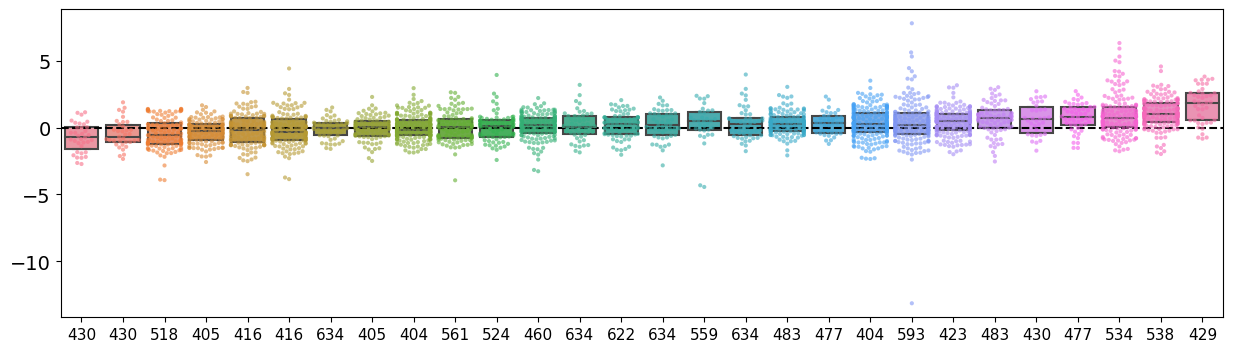

In [61]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset=['T'])

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=res_dropna, vc_formula=vcf, groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_dropna, key='T')
plt.figure(figsize=(15, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);


### Do *any* electrodes show a significant theta response?

In [56]:
from codebase import filter_dict

sig_pos = res_dropna[(res_dropna['pval']<0.05) & (res_dropna['T']>0)]
sig_neg = res_dropna[(res_dropna['pval']<0.05) & (res_dropna['T']<0)]

from scipy.stats import binom_test
print(binom_test(len(sig_pos), len(res_dropna[res_dropna['T']>0]), 0.05, alternative='greater'))
print(binom_test(len(sig_neg), len(res_dropna[res_dropna['T']<0]), 0.05, alternative='greater'))

# Now do only for MTL w/ parietal stim
mtl_par = res_dropna[(res_dropna['MTL']==True) & (res_dropna['target'].str.contains('Parietal'))]

# Now only for DLPFC stim w/ frontal response
dlpfc_fron = res_dropna[(res_dropna['DKT_label'].str.contains(filter_dict['frontal_filter'])) & (res_dropna['target'].str.contains('DLPFC'))]
print(binom_test(len(dlpfc_fron[(dlpfc_fron['T']>0) & (dlpfc_fron['pval']<0.05)]), len(dlpfc_fron[dlpfc_fron['T']>0]), 0.05, alternative='greater'))
print(binom_test(len(dlpfc_fron[(dlpfc_fron['T']<0) & (dlpfc_fron['pval']<0.05)]), len(dlpfc_fron[dlpfc_fron['T']<0]), 0.05, alternative='greater'))

0.7452405213498015
0.6977302260260227
0.07460613137795764
0.1821180273989012


The answer is NO: looking at the whole dataset and within key region/target pairs, the number of p<0.05 significant electrodes is never greater than the number expected by chance alone.

_Restrict analysis to single hemisphere_

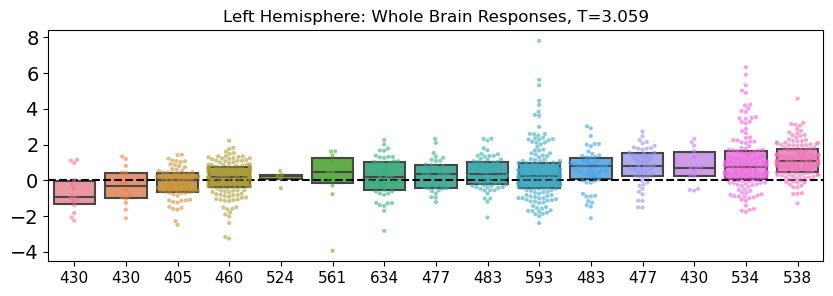

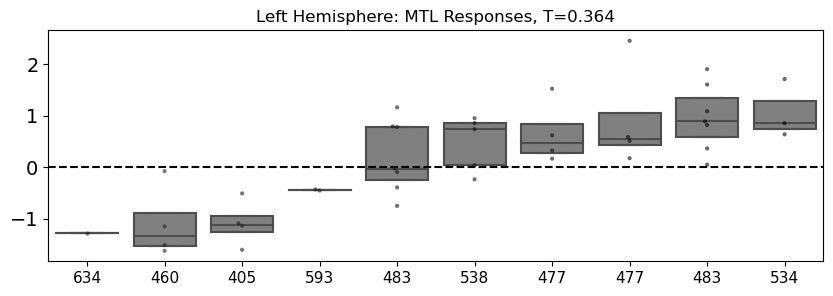

In [6]:
# First do LEFT
res_L = res_dropna[(res_dropna['anatX']<0) & ( (res_dropna['target_x']<0) | (res_dropna['target'].str.contains('L_')) )]

vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=res_L, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_L, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Left Hemisphere: Whole Brain Responses, T='+str(np.round(result.tvalues[0], 3)));

### MTL subset ###
mtl_filter = (res_L['DKT_label'].str.contains('hipp')) | (res_L['DKT_label'].str.contains('ento')) | (res_L['DKT_label'].str.contains('Hipp'))
mtl_data = res_L[mtl_filter]

vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=mtl_data, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(mtl_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6, color='black')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='gray')
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Left Hemisphere: MTL Responses, T='+str(np.round(result.tvalues[0], 3)));

C:\Users\esolo\anaconda3\envs\mne2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


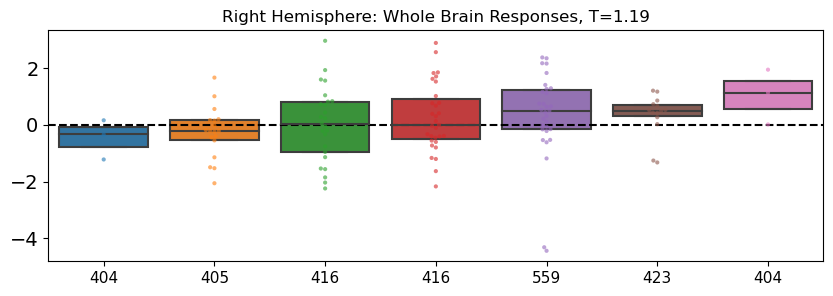

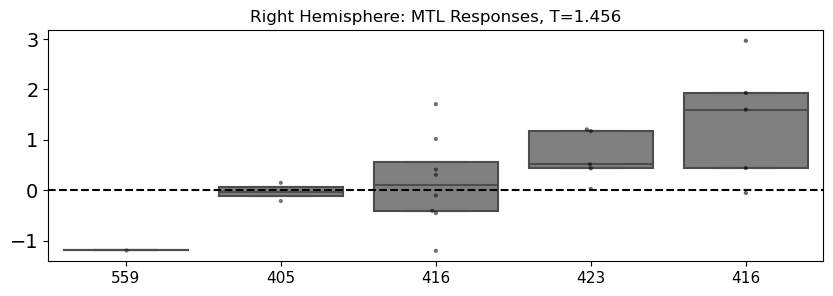

In [7]:
# Now do RIGHT
res_R = res_dropna[(res_dropna['anatX']>0) & ( (res_dropna['target_x']>0) | (res_dropna['target'].str.contains('R_')) )]

vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=res_R, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_R, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Right Hemisphere: Whole Brain Responses, T='+str(np.round(result.tvalues[0], 3)));

### MTL subset ###
mtl_filter = (res_R['DKT_label'].str.contains('hipp')) | (res_R['DKT_label'].str.contains('ento')) | (res_R['DKT_label'].str.contains('Hipp'))
mtl_data = res_R[mtl_filter]

vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=mtl_data, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(mtl_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6, color='black')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='gray')
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Right Hemisphere: MTL Responses, T='+str(np.round(result.tvalues[0], 3)));

_Analyze response within each region (w/ sufficient electrodes)_

In [8]:
# Only do the subregion analysis 
import warnings
warnings.filterwarnings("ignore")   # many of the low-N regions will fail to converge (should use classic stats instead)

sense_region_result = pd.DataFrame()

for tg in ['Parietal', 'DLPFC']:  # only parietal and DLPFC stim have enough subjects
    
    df = res_dropna[res_dropna['target'].str.contains(tg)]
    sense_regions = df['DKT_label'].unique() # Identify the unique regions sampled in this dataset
    
    for r in sense_regions: 
        reg_df = df[df['DKT_label']==r]
        if len(reg_df)<10:  # too few electrodes to analyze an effect reliably
            continue
            
        if len(reg_df['subject'].unique())<3:   # too few subjects to analyze an effect reliably
            continue
        
        # No variance component needed since we are already looking at only one stim region
        model = sm.MixedLM.from_formula("T ~ 1", data=reg_df, groups='subject')
        result = model.fit(reml=True)

        mydict = {'sense_region': r, 'stim_region': tg, 't': result.tvalues[0], 'p': result.pvalues[0], 'elec_count': len(reg_df), 
                  'sub_count': len(reg_df['subject'].unique())}
        sense_region_result = sense_region_result.append(mydict, ignore_index=True)
        
from mne.stats import fdr_correction
sense_region_result.iloc[fdr_correction(sense_region_result['p'], 0.05)[0]]

,sense_region,stim_region,t,p,elec_count,sub_count
14,Left-Hippocampus,Parietal,4.023481,5.734428e-05,11,5
26,Ctx-rh-lateralorbitofrontal,DLPFC,3.885397,1.021626e-04,52,9
42,Ctx-lh-supramarginal,DLPFC,3.450676,5.591842e-04,63,9
44,Ctx-lh-lateralorbitofrontal,DLPFC,3.365100,7.651579e-04,33,6
53,Ctx-lh-medialorbitofrontal,DLPFC,5.128198,2.925285e-07,16,7
56,Ctx-lh-isthmuscingulate,DLPFC,2.823123,4.755830e-03,16,6
57,Ctx-lh-posteriorcingulate,DLPFC,4.555584,5.224028e-06,20,6


**DLPFC only stimulation**

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T         
No. Observations: 1297    Method:             REML      
No. Groups:       14      Scale:              0.9169    
Min. group size:  33      Log-Likelihood:     -1805.7749
Max. group size:  173     Converged:          Yes       
Mean group size:  92.6                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   0.049     0.129  0.381  0.703  -0.204   0.303
g1 Var      0.221     0.095                              



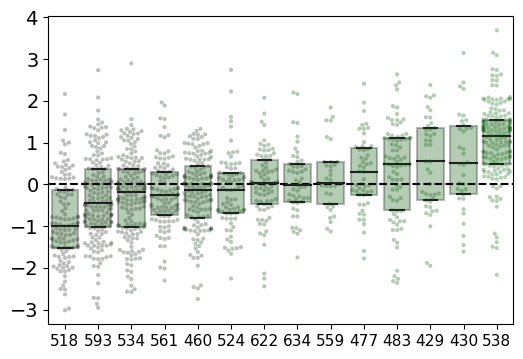

In [19]:
dlpfc_res = res_dropna[res_dropna['target'].str.contains('DLPFC')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=dlpfc_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=True)
print(result.summary())

#dlpfc_region, _ = sig_elecs_by_region(dlpfc_res)
#dlpfc_region

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(dlpfc_res, key='T')
plt.figure(figsize=(6, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkgreen', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkgreen', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

**Parietal only stimulation**

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T        
No. Observations: 661     Method:             REML     
No. Groups:       6       Scale:              0.9182   
Min. group size:  36      Log-Likelihood:     -917.4843
Max. group size:  179     Converged:          Yes      
Mean group size:  110.2                                
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.082     0.132  0.618  0.536  -0.177   0.341
g1 Var     0.094     0.068                              



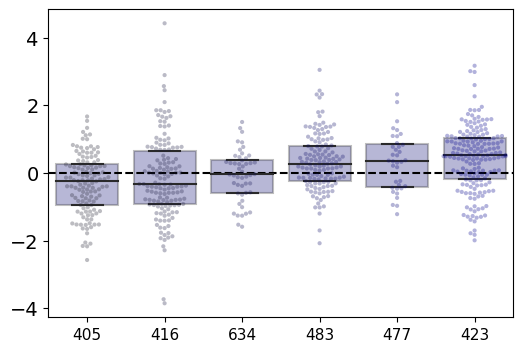

In [10]:
par_res = res_dropna[res_dropna['target'].str.contains('Parietal')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=par_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=True)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(par_res, key='T')
plt.figure(figsize=(6, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkblue', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkblue', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

**STG only stimulation**

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T        
No. Observations: 408     Method:             REML     
No. Groups:       3       Scale:              0.9623   
Min. group size:  85      Log-Likelihood:     -573.0022
Max. group size:  198     Converged:          Yes      
Mean group size:  136.0                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.070    0.059 -1.196 0.232 -0.185  0.045
g1 Var        0.003    0.010                           



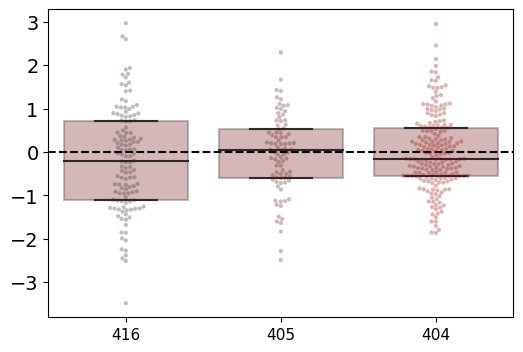

In [11]:
stg_res = res_dropna[res_dropna['target'].str.contains('STG')]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=stg_res, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=True)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(stg_res, key='T')
plt.figure(figsize=(6, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, color='darkred', alpha=0.3)
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkred', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);

## Analyze hippocampal/MTL responses

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T       
No. Observations: 66      Method:             ML      
No. Groups:       12      Scale:              0.5272  
Min. group size:  1       Log-Likelihood:     -78.8505
Max. group size:  18      Converged:          Yes     
Mean group size:  5.5                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   -0.292    0.145 -2.020 0.043 -0.575 -0.009
g1 Var       0.166    0.186                           



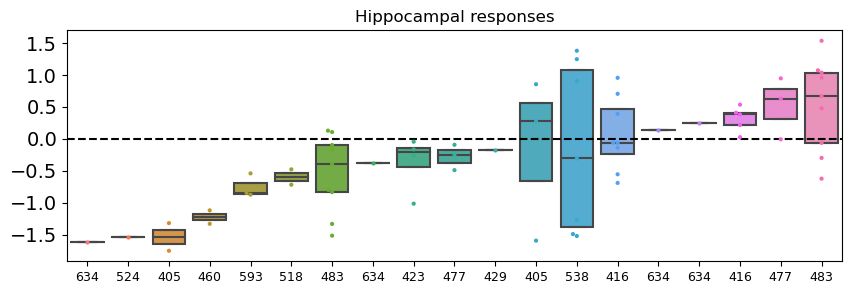

In [13]:
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset='T')

# Isolate hippocampal responses
hipp_data = res_dropna[(res_dropna['DKT_label'].str.contains('Hipp'))]

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=hipp_data, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(hipp_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3,)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('Hippocampal responses');

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: T        
No. Observations: 108     Method:             ML       
No. Groups:       16      Scale:              0.6557   
Min. group size:  1       Log-Likelihood:     -138.5310
Max. group size:  24      Converged:          Yes      
Mean group size:  6.8                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.050    0.125 -0.397 0.691 -0.295  0.196
g1 Var        0.167    0.162                           



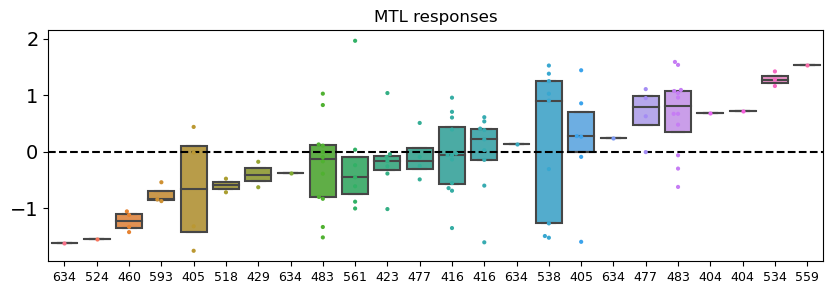

In [14]:
# What about MTL electrodes?
mtl_filter = (res_dropna['DKT_label'].str.contains('hipp')) | (res_dropna['DKT_label'].str.contains('ento')) | (res_dropna['DKT_label'].str.contains('Hipp'))
mtl_data = res_dropna[mtl_filter]

vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1", data=mtl_data, 
                                vc_formula=vcf,
                                groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(mtl_data, key='T')
plt.figure(figsize=(10, 3)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3,)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.title('MTL responses');

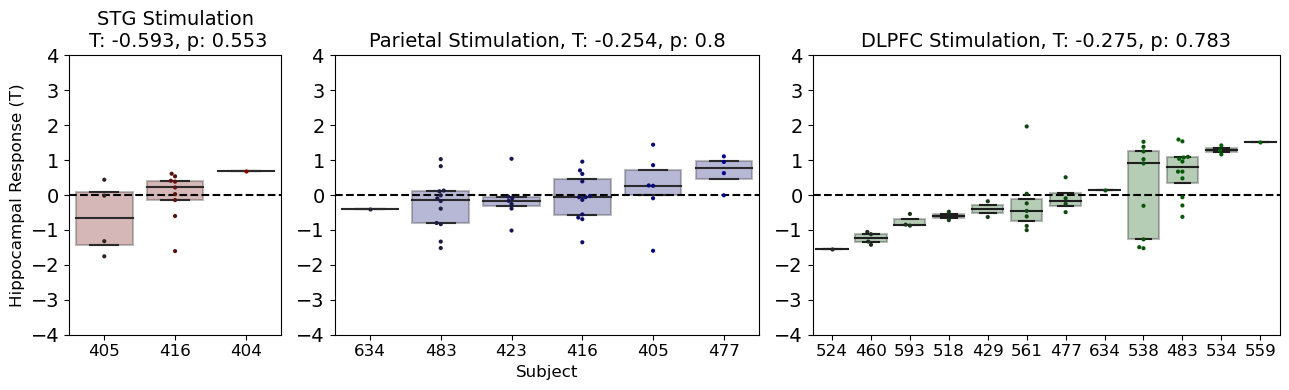

In [18]:
from matplotlib import gridspec

par_mtl = mtl_data[mtl_data['target'].str.contains('Parietal')]
dlpfc_mtl = mtl_data[mtl_data['target'].str.contains('DLPFC')]
stg_mtl = mtl_data[mtl_data['target'].str.contains('STG')]

res_par = sm.MixedLM.from_formula("T ~ 1", data=par_mtl, vc_formula=vcf, groups='subject').fit(reml=True)
res_dlpfc = sm.MixedLM.from_formula("T ~ 1", data=dlpfc_mtl, vc_formula=vcf, groups='subject').fit(reml=True)
res_stg = sm.MixedLM.from_formula("T ~ 1", data=stg_mtl, vc_formula=vcf, groups='subject').fit(reml=True)

# Plot results
plt.figure(figsize=(13, 4));
gs = gridspec.GridSpec(1, 3, width_ratios = [1, 2, 2.2])

#STG
ax1 = plt.subplot(gs[0])
data_toplot, sub_toplot = swarmplot_subjects(stg_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkred')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkred', boxprops=dict(alpha=.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14); plt.ylabel('Hippocampal Response (T)', fontsize=12)
plt.ylim(-4, 4)
plt.title('STG Stimulation\n T: '+str(np.round(res_stg.tvalues[0], 3))+', p: '+str(np.round(res_stg.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12)

#Parietal
ax2 = plt.subplot(gs[1])
data_toplot, sub_toplot = swarmplot_subjects(par_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkblue')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkblue', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax2.get_xlim()[0], xmax=ax2.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.ylim(-4, 4)
plt.title('Parietal Stimulation, T: '+str(np.round(res_par.tvalues[0], 3))+', p: '+str(np.round(res_par.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12); plt.xlabel('Subject', fontsize=12)

#DLPFC
ax3 = plt.subplot(gs[2])
data_toplot, sub_toplot = swarmplot_subjects(dlpfc_mtl, key='T')
sns.swarmplot(data=data_toplot, size=3, color='darkgreen')
sns.boxplot(data=data_toplot, whis=0, showfliers=False, color='darkgreen', boxprops=dict(alpha=0.3))
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=9);
plt.hlines([0], xmin=ax3.get_xlim()[0], xmax=ax3.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
plt.ylim(-4, 4)
plt.title('DLPFC Stimulation, T: '+str(np.round(res_dlpfc.tvalues[0], 3))+', p: '+str(np.round(res_dlpfc.pvalues[0], 3)), fontsize=14);
plt.xticks(fontsize=12)
plt.tight_layout()
#plt.savefig('./TMSEEG_plots/LMM_hippocampal_theta_1.1_2.1sec.pdf')

## Analyze distance-based measures

                        Mixed Linear Model Regression Results
Model:                       MixedLM          Dependent Variable:          T         
No. Observations:            2464             Method:                      ML        
No. Groups:                  16               Scale:                       1.3127    
Min. group size:             33               Log-Likelihood:              -3866.0977
Max. group size:             398              Converged:                   Yes       
Mean group size:             154.0                                                   
-------------------------------------------------------------------------------------
                                             Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                    0.049    0.121 0.405 0.686 -0.188  0.285
C(distance_category, Treatment(1))[T.close]  0.331    0.074 4.464 0.000  0.185

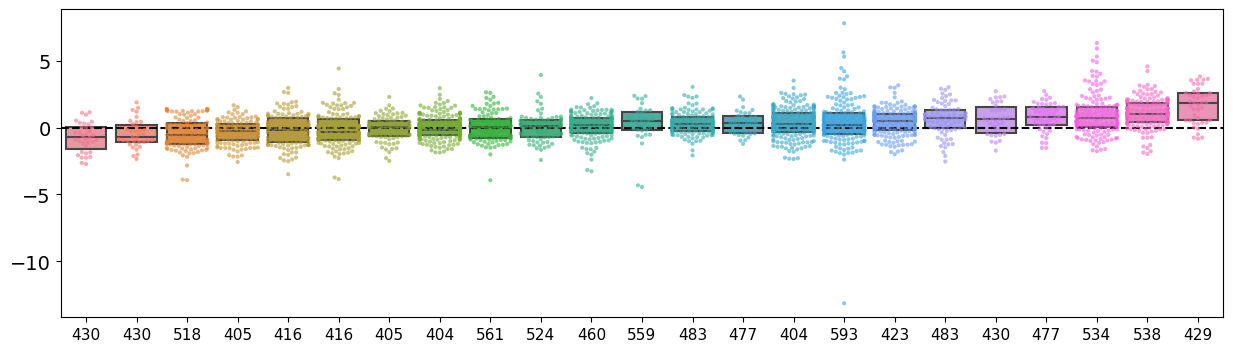

In [13]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset=['T', 'distance_category'])

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1 + C(distance_category, Treatment(1))", data=res_dropna, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_dropna, key='T')
plt.figure(figsize=(15, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
#plt.savefig('./TMSEEG_plots/LMM_distribution_plot_gamma_1.1_2.1sec.pdf')

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: T         
No. Observations:   2464    Method:             ML        
No. Groups:         16      Scale:              0.8486    
Min. group size:    33      Log-Likelihood:     -3327.0853
Max. group size:    398     Converged:          Yes       
Mean group size:    154.0                                 
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.062    0.085  0.726 0.468 -0.105  0.230
target_distance -0.027    0.025 -1.094 0.274 -0.076  0.022
g1 Var           0.156    0.053                           



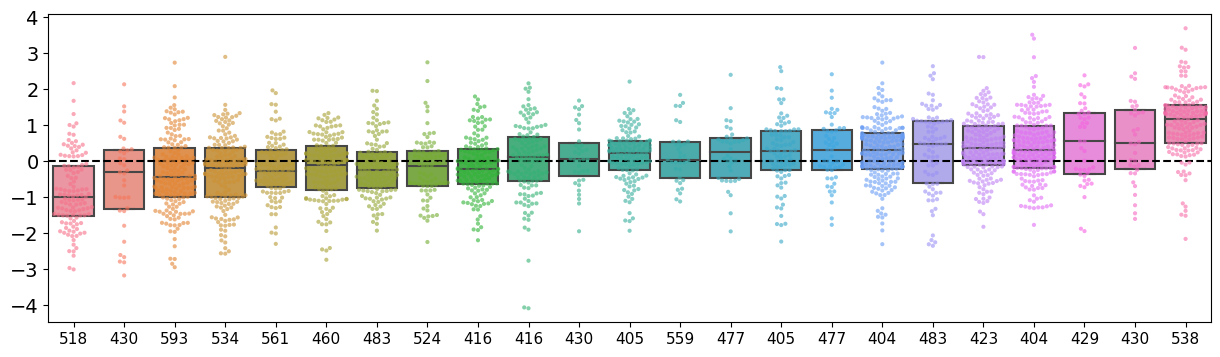

In [19]:
from utils import swarmplot_subjects
import statsmodels.api as sm
import seaborn as sns

# Need to drop some electrodes with NaNs (small amount of source EEG data contaminated with NaNs)
res_dropna = res.dropna(subset=['T', 'distance_category'])

# Sessions nested within subjects LMM, specifying subjects as random effects
vcf = {'g1':'0+C(target)'}
model = sm.MixedLM.from_formula("T ~ 1 + target_distance", data=res_dropna, 
                               vc_formula=vcf,
                               groups='subject')
result = model.fit(reml=False)
print(result.summary())

# Plot results
data_toplot, sub_toplot = swarmplot_subjects(res_dropna, key='T')
plt.figure(figsize=(15, 4)); ax1=plt.subplot(111)
sns.swarmplot(data=data_toplot, size=3, alpha=0.6)
sns.boxplot(data=data_toplot, whis=0, showfliers=False)
plt.xticks(np.arange(len(sub_toplot)), sub_toplot, fontsize=11);
plt.hlines([0], xmin=ax1.get_xlim()[0], xmax=ax1.get_xlim()[1], linestyles='--', color='k')
plt.yticks(fontsize=14);
#plt.savefig('./TMSEEG_plots/LMM_distribution_plot_gamma_1.1_2.1sec.pdf')

### Plot changes in power sorted by stim region

#### Many stim sites vs. one response region

In [14]:
import pandas as pd
import numpy as np
import pylab as plt

res = pd.read_pickle('./multitaper_power/multitaper_power_0.05_0.55_3-8Hz.pkl')

# Simplest method: apply a T-value threshold (only expect this in the positive direction)
#res = res[res['T']<5]

# Remove saturated electrodes
res = res[res['saturated']==False]

# Remove noisy electrodes
res = res[res['noisy']==False]

# Remove epileptogenic electrodes
res = res[res['Seizure_Exclude']!=1]

# Z-score the distances
from scipy.stats import zscore
res['target_distance'] = zscore(res['target_distance'], nan_policy='omit')

In [15]:
# Analyze within-hemisphere responses to stimulation
import warnings; warnings.filterwarnings("ignore");
from codebase import *

sub_Ts = pd.DataFrame(columns=['subject', 'hemis', 'target', 'mean_power'])

for i in [ ('Left', 'DLPFC'), ('Right', 'DLPFC'), ('Left', 'Parietal'), ('Right', 'Parietal'), ('Left', 'STG'), ('Right', 'STG')]:   # loop through possible stim sites
    for sub in res['subject'].unique():
        t_sub = res[res['subject']==sub]
        
        hemis = i[0]; target = i[1];
        
        # Figure out which side the target was on
        stim_side = []
        for idx in range(len(t_sub)):
            myside='None'
            if t_sub['target_x'].iloc[idx]<0:
                myside='Left'
            elif t_sub['target_x'].iloc[idx]>0:
                myside='Right'
            elif t_sub['target'].iloc[idx][0]=='R':
                myside='Right'
            elif t_sub['target'].iloc[idx][0]=='L':
                myside='Left'
            else:
                # Can do this final check if only one side is sampled at all (only necessary for subject 622)
                if len(t_sub['Side'].unique())==1:
                    myside=t_sub['Side'].iloc[0]
            stim_side.append(myside)
        stim_side = np.array(stim_side)
        
        # Find ITC vs distance correlation within-subject and within-hemisphere
        toplot = t_sub[(t_sub['target'].str.contains(target)) & (stim_side==hemis)]
            
        # Subselect by sense contacts within a given region (lobe-level?)
        filt = 'r_mtl_filter'
        toplot = toplot[toplot['DKT_label'].str.contains(filter_dict[filt])]
        
        # Sometimes there is no data given the filters
        if len(toplot)==0:
            continue

        sub_Ts = pd.concat([sub_Ts, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis,
                                                  'mean_power': np.nanmean(toplot['T']), 'sense_region':filt}, index=[0])], ignore_index=True)
    
sub_Ts

,subject,hemis,target,mean_power,sense_region
0,429,Left,DLPFC,0.302376,r_mtl_filter
1,483,Left,DLPFC,-0.198029,r_mtl_filter
2,524,Left,DLPFC,-1.353275,r_mtl_filter
3,538,Left,DLPFC,-1.364561,r_mtl_filter
4,518,Left,DLPFC,1.298258,r_mtl_filter
5,561,Left,DLPFC,-0.189590,r_mtl_filter
6,593,Left,DLPFC,0.009176,r_mtl_filter
7,559,Right,DLPFC,-1.183257,r_mtl_filter
8,483,Left,Parietal,0.303606,r_mtl_filter
9,405,Right,Parietal,-0.033546,r_mtl_filter


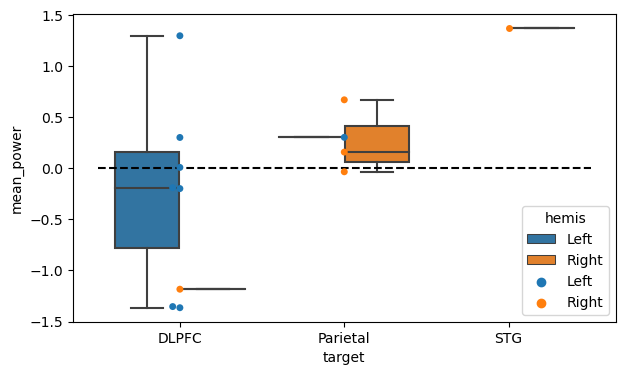

In [16]:
import seaborn as sns
plt.figure(figsize=(7, 4)); ax=plt.subplot(111)
sns.boxplot(data=sub_Ts, x='target', y='mean_power', hue='hemis')
sns.swarmplot(data=sub_Ts, x='target', y='mean_power', hue='hemis')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')

#### Timecourse of stim response, sorted by stim location

In [4]:
def get_stim_side(t_sub):
    stim_side = []
    for idx in range(len(t_sub)):
        myside='None'
        if t_sub['target_x'].iloc[idx]<0:
            myside='Left'
        elif t_sub['target_x'].iloc[idx]>0:
            myside='Right'
        elif t_sub['target'].iloc[idx][0]=='R':
            myside='Right'
        elif t_sub['target'].iloc[idx][0]=='L':
            myside='Left'
        else:
            # Can do this final check if only one side is sampled at all (only necessary for subject 622)
            if len(t_sub['Side'].unique())==1:
                myside=t_sub['Side'].iloc[0]
        stim_side.append(myside)
    stim_side = np.array(stim_side)
    
    return stim_side

In [30]:
from codebase import filter_dict
import warnings; warnings.filterwarnings("ignore");

freq_band = '3-8Hz'
start_times = np.arange(0.05, 0.55, 0.1)
win_size = 0.5
stim_site = ('Both', 'Parietal')

# Instantiate dataframe
sub_Ts = pd.DataFrame()

for st in start_times:
    fn = './multitaper_power/multitaper_power_'+str(np.around(st, 4))+'_'+str(np.round(st+win_size, 4))+'_'+freq_band+'.pkl'
    
    # Load the data and remove bad electrodes
    res = pd.read_pickle(fn)
    res = res[res['saturated']==False]
    res = res[res['noisy']==False]
    res = res[res['Seizure_Exclude']!=1]
    
    for sub in res['subject'].unique():
        t_sub = res[res['subject']==sub]
        
        hemis = stim_site[0]; target = stim_site[1];
        
        # Figure out which hemisphere the target was on
        stim_side = get_stim_side(t_sub)
        
        # Subselect by target and hemisphere
        if hemis=='Both':
            toplot = t_sub[(t_sub['target'].str.contains(target))]
        else:
            toplot = t_sub[(t_sub['target'].str.contains(target)) & (stim_side==hemis)]
        
        if len(toplot)==0:
            continue
        
        for filt in filter_dict.keys():
            toplot_filt = toplot[toplot['DKT_label'].str.contains(filter_dict[filt])]
                            
            # Sometimes there is no data given the filters
            if len(toplot_filt)==0:
                continue

            sub_Ts = pd.concat([sub_Ts, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis,
                                                      'mean_power': np.nanmean(toplot_filt['T']), 'sense_region':filt,
                                                     'start_time': st, 'win_size': win_size,
                                                     'num_sense_elecs': len(toplot_filt)}, index=[0])], ignore_index=True)

L DLPFC stats: T:[3.9338202314132578, 3.455914095697453, 2.8306607632217466, 2.493192290127054, 2.1622167376522787], p: [0.004333354159407612, 0.008619444488063765, 0.02212769456845617, 0.037336021279378344, 0.06257289134726975]
Control region stats: T:[2.386704704898123, 2.2665816332651616, 0.9754652086699901, 0.2728083955622246, -0.339095085509143], p: [0.019830627015272422, 0.026649441980178996, 0.3328384413338632, 0.7858395899710874, 0.7355986361934013]


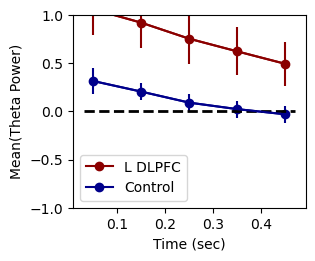

In [147]:
from scipy.stats import sem, ttest_1samp

# Plot results for L DLPFC stim
s_region = sub_Ts[sub_Ts['sense_region']=='r_frontal_filter']

mu = []; sem_ = []; X = []; t_ = []; p_ = [];
for s in s_region['start_time'].unique():
    X.append(s)
    mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
    sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
    t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
    t_.append(t); p_.append(p)
    
print('L DLPFC stats: T:'+str(t_)+', p: '+str(p_))
plt.figure(figsize=(3, 2.5)); ax=plt.subplot(111)
plt.plot(X, mu, 'o-', color='darkred', label='L DLPFC')
plt.errorbar(X, mu, yerr=sem_, color='darkred')
plt.ylabel('Mean(Theta Power)'); plt.xlabel('Time (sec)')

# Now plot for control (non-DLPFC) regions
s_region = sub_Ts[sub_Ts['sense_region']!='l_frontal_filter']

mu = []; sem_ = []; X = []; t_ = []; p_ = [];
for s in s_region['start_time'].unique():
    X.append(s)
    mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
    sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
    t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
    t_.append(t); p_.append(p)
    
print('Control region stats: T:'+str(t_)+', p: '+str(p_))
plt.plot(X, mu, 'o-', color='darkblue', label='Control')
plt.errorbar(X, mu, yerr=sem_, color='darkblue')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
plt.ylim(-1, 1)
plt.legend()

#plt.savefig('./multitaper_epo_plots/L_DLPFC_stim-L_DLPFC_sense.pdf')

frontal stats: T:[0.7260907711478313, 0.19990008261985773, 0.26275256947522946, 0.11792949081236678, -0.06110606287920661], p: [0.507991380224185, 0.851310111925213, 0.8057195372914957, 0.9118082136451091, 0.9542060690316119]
temporal stats: T:[0.08132318659364382, -0.3617292942908515, -0.25186517038699974, -0.32932545658336004, 0.9326674809098838], p: [0.938339884441695, 0.7323383615692902, 0.8111702481760706, 0.7552574724243125, 0.39380336864226845]
parietal stats: T:[-0.22459990060268903, -0.7108809888294944, -1.1635693016940907, -0.622318600790387, 0.717917480103409], p: [0.8332972524345834, 0.516412990085742, 0.30927528206430527, 0.567450640943493, 0.512504242169923]
mtl stats: T:[4.8676272348553375, 2.91814348469056, 2.264085969720017, 1.365501691994171, 0.013652866113471865], p: [0.004602391042239088, 0.033085022473520485, 0.07297721827625164, 0.23031866182948982, 0.9896349477839772]
limbic stats: T:[2.8315738160966992, 3.713133745107406, 3.1933946700958646, 1.421327801565025, 0

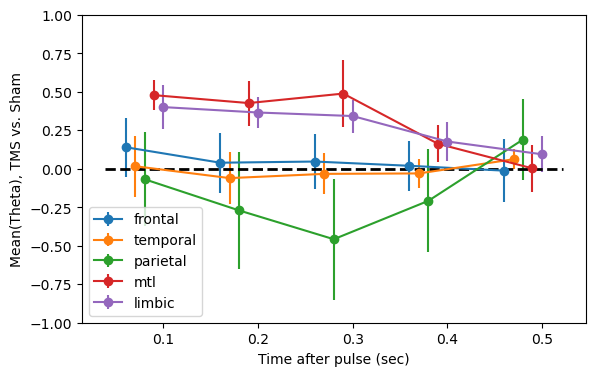

In [31]:
from scipy.stats import sem, ttest_1samp

plt.figure(figsize=(6.5, 4)); ax=plt.subplot(111)

# Loop through regions
x_shift=0.01  # for plotting purposes
for sense_lobe in ['frontal_filter', 'temporal_filter', 'parietal_filter', 'mtl_filter', 'limbic_filter']:
    # if sense_lobe[0]=='r':
    #     pass
    # else:
    #     continue
        
    s_region = sub_Ts[sub_Ts['sense_region']==sense_lobe]

    mu = []; sem_ = []; X = []; t_ = []; p_ = [];
    for s in s_region['start_time'].unique():
        X.append(s)
        mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
        sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
        t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
        t_.append(t); p_.append(p)
    
    # Plot results
    print(sense_lobe.split('_')[0]+' stats: T:'+str(t_)+', p: '+str(p_))
    #plt.plot(X, mu, 'o-', label=sense_lobe.split('_')[1])
    plt.errorbar(np.array(X)+x_shift, mu, yerr=sem_, label=sense_lobe.split('_')[0], marker='o')
    x_shift = x_shift+0.01
    
# Finish plot
plt.ylabel('Mean(Theta), TMS vs. Sham'); plt.xlabel('Time after pulse (sec)')
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
plt.ylim(-1, 1)
plt.legend(loc=3)

#plt.savefig('./multitaper_epo_plots/R_Parietal_stim-L_Limbic_sense.pdf')

#### Timecourse of stim response, sorted by response location

In [54]:
from codebase import filter_dict
import warnings; warnings.filterwarnings("ignore");

freq_band = '70-110Hz'
start_times = np.arange(0.05, 0.55, 0.1)
win_size = 0.25

# Instantiate dataframe
sub_Ts = pd.DataFrame()

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal'), ('Both', 'STG')]:

    for st in start_times:
        fn = './multitaper_power/multitaper_power_'+str(np.around(st, 4))+'_'+str(np.round(st+win_size, 4))+'_'+freq_band+'.pkl'

        # Load the data and remove bad electrodes
        res = pd.read_pickle(fn)
        res = res[res['saturated']==False]
        res = res[res['noisy']==False]
        res = res[res['Seizure_Exclude']!=1]

        for sub in res['subject'].unique():
            t_sub = res[res['subject']==sub]

            hemis = stim_site[0]; target = stim_site[1];

            # Figure out which hemisphere the target was on
            stim_side = get_stim_side(t_sub)

            # Subselect by target and hemisphere
            if hemis=='Both':
                toplot = t_sub[(t_sub['target'].str.contains(target))]
            else:
                toplot = t_sub[(t_sub['target'].str.contains(target)) & (stim_side==hemis)]

            if len(toplot)==0:
                continue

            for filt in filter_dict.keys():
                toplot_filt = toplot[toplot['DKT_label'].str.contains(filter_dict[filt])]

                # Sometimes there is no data given the filters
                if len(toplot_filt)==0:
                    continue
                
                # hemis denotes the stimulated hemisphere
                sub_Ts = pd.concat([sub_Ts, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis,
                                                          'mean_power': np.nanmean(toplot_filt['T']), 'sense_region':filt.replace('_filter', ''),
                                                         'start_time': st, 'win_size': win_size,
                                                         'num_sense_elecs': len(toplot_filt)}, index=[0])], ignore_index=True)

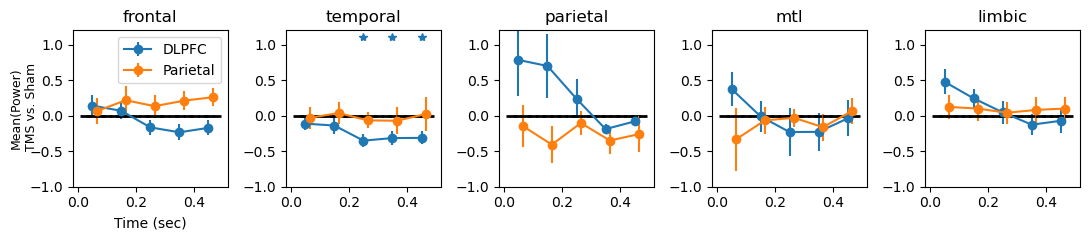

In [56]:
from scipy.stats import sem, ttest_1samp
from mne.stats import fdr_correction

plt.figure(figsize=(11, 2.5)); 
alpha = 0.05

# Loop through stim sites
x_shift=0  # for subplotting

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal')]:
    
    c = 1; 

    stim_subdf = sub_Ts[(sub_Ts['target'].str.contains(stim_site[1])) & (sub_Ts['hemis'].str.contains(stim_site[0]))]

    for sense_lobe in ['frontal', 'temporal', 'parietal', 'mtl', 'limbic']:

        s_region = stim_subdf[stim_subdf['sense_region']==sense_lobe]

        mu = []; sem_ = []; X = []; t_ = []; p_ = [];
        
        for s in s_region['start_time'].unique():
            X.append(s)
            mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
            sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
            t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
            t_.append(t); p_.append(p); 

        # Plot results
        X = np.array(X)
        ax=plt.subplot(1,5,c)
        line = plt.errorbar(np.array(X)+x_shift, mu, yerr=sem_, label=stim_site[1], marker='o')
        plt.plot(X[fdr_correction(p_, alpha)[0]]+x_shift, [1.1]*fdr_correction(p_, alpha)[0].sum(), marker='*', color=line[0].get_color(), 
                linewidth=0)
        plt.title(sense_lobe.split('_')[0])
        plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k', linewidth=2)
        plt.ylim(-1, 1.2)
        
        if c==1:
            plt.legend(loc=0)
            plt.xlabel('Time (sec)')
            plt.ylabel('Mean(Power)\n TMS vs. Sham', fontsize=9, va='center')
        
        c = c+1
        
    x_shift = x_shift+0.015

# Finish plot    
plt.tight_layout()
    
# Finish plot
#plt.ylabel('Mean(Theta), TMS vs. Sham'); plt.xlabel('Time after pulse (sec)')
#plt.legend(loc=3)

plt.savefig('./multitaper_epo_plots/response_region_by_stim_HFA.pdf')

- Subject 423 has high MTL theta response to parietal stim

**In an exploratory analysis, look at MTL subregions**

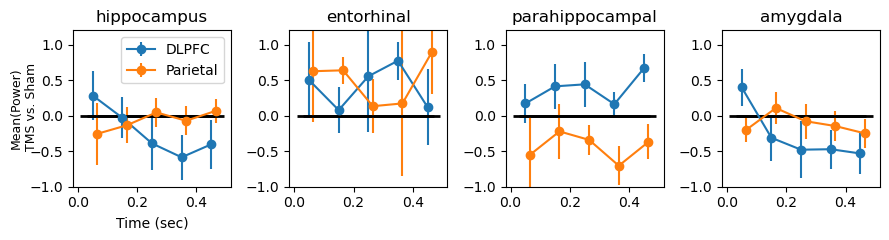

In [32]:
from codebase import filter_dict
import warnings; warnings.filterwarnings("ignore");

freq_band = '70-110Hz'
start_times = np.arange(0.05, 0.55, 0.1)
win_size = 0.25

# Instantiate dataframe
sub_Ts = pd.DataFrame()

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal'), ('Both', 'STG')]:

    for st in start_times:
        fn = './multitaper_power/multitaper_power_'+str(np.around(st, 4))+'_'+str(np.round(st+win_size, 4))+'_'+freq_band+'.pkl'

        # Load the data and remove bad electrodes
        res = pd.read_pickle(fn)
        res = res[res['saturated']==False]
        res = res[res['noisy']==False]
        res = res[res['Seizure_Exclude']!=1]

        for sub in res['subject'].unique():
            t_sub = res[res['subject']==sub]

            hemis = stim_site[0]; target = stim_site[1];

            # Figure out which hemisphere the target was on
            stim_side = get_stim_side(t_sub)

            # Subselect by target and hemisphere
            if hemis=='Both':
                toplot = t_sub[(t_sub['target'].str.contains(target))]
            else:
                toplot = t_sub[(t_sub['target'].str.contains(target)) & (stim_side==hemis)]

            if len(toplot)==0:
                continue

            for filt in filter_dict.keys():
                toplot_filt = toplot[toplot['DKT_label'].str.contains(filter_dict[filt])]

                # Sometimes there is no data given the filters
                if len(toplot_filt)==0:
                    continue
                
                # hemis denotes the stimulated hemisphere
                sub_Ts = pd.concat([sub_Ts, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis,
                                                          'mean_power': np.nanmean(toplot_filt['T']), 'sense_region':filt.replace('_filter', ''),
                                                         'start_time': st, 'win_size': win_size,
                                                         'num_sense_elecs': len(toplot_filt)}, index=[0])], ignore_index=True)

### PLOT RESULTS ###
from scipy.stats import sem, ttest_1samp
from mne.stats import fdr_correction

plt.figure(figsize=(9, 2.5)); 
alpha = 0.05

# Loop through stim sites
x_shift=0  # for subplotting

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal')]:
    
    c = 1; 

    stim_subdf = sub_Ts[(sub_Ts['target'].str.contains(stim_site[1])) & (sub_Ts['hemis'].str.contains(stim_site[0]))]

    for sense_lobe in ['hippocampus', 'entorhinal', 'parahippocampal', 'amygdala']:

        s_region = stim_subdf[stim_subdf['sense_region']==sense_lobe]

        mu = []; sem_ = []; X = []; t_ = []; p_ = [];
        
        for s in s_region['start_time'].unique():
            X.append(s)
            mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
            sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
            t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
            t_.append(t); p_.append(p); 

        # Plot results
        X = np.array(X)
        ax=plt.subplot(1,4,c)
        line = plt.errorbar(np.array(X)+x_shift, mu, yerr=sem_, label=stim_site[1], marker='o')
        plt.plot(X[fdr_correction(p_, alpha)[0]]+x_shift, [1.1]*fdr_correction(p_, alpha)[0].sum(), marker='*', color=line[0].get_color(), 
                linewidth=0)
        plt.title(sense_lobe.split('_')[0])
        plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='-', color='k', linewidth=2)
        plt.ylim(-1, 1.2)
        
        if c==1:
            plt.legend(loc=0)
            plt.xlabel('Time (sec)')
            plt.ylabel('Mean(Power)\n TMS vs. Sham', fontsize=9, va='center')
        
        c = c+1
        
    x_shift = x_shift+0.015

# Finish plot    
plt.tight_layout()
    
# Finish plot
#plt.ylabel('Mean(Theta), TMS vs. Sham'); plt.xlabel('Time after pulse (sec)')
#plt.legend(loc=3)

#plt.savefig('./multitaper_epo_plots/response_region_by_stim_HFA.pdf')

**Look at key regions of interest by DKT label**

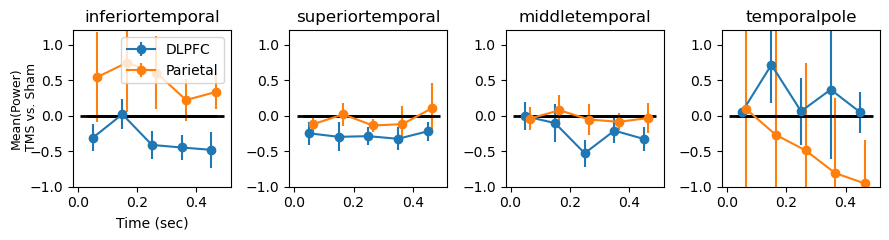

In [31]:
from codebase import filter_dict
import warnings; warnings.filterwarnings("ignore");

# Parameters
freq_band = '70-110Hz'
start_times = np.arange(0.05, 0.55, 0.1)
win_size = 0.25
rois = ['inferiortemporal', 'superiortemporal', 'middletemporal', 'temporalpole']

# Instantiate dataframe
sub_Ts = pd.DataFrame()

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal'), ('Both', 'STG')]:

    for st in start_times:
        fn = './multitaper_power/multitaper_power_'+str(np.around(st, 4))+'_'+str(np.round(st+win_size, 4))+'_'+freq_band+'.pkl'

        # Load the data and remove bad electrodes
        res = pd.read_pickle(fn)
        res = res[res['saturated']==False]
        res = res[res['noisy']==False]
        res = res[res['Seizure_Exclude']!=1]

        for sub in res['subject'].unique():
            t_sub = res[res['subject']==sub]

            hemis = stim_site[0]; target = stim_site[1];

            # Figure out which hemisphere the target was on
            stim_side = get_stim_side(t_sub)

            # Subselect by target and hemisphere
            if hemis=='Both':
                toplot = t_sub[(t_sub['target'].str.contains(target))]
            else:
                toplot = t_sub[(t_sub['target'].str.contains(target)) & (stim_side==hemis)]

            if len(toplot)==0:
                continue

            for filt in rois:
                toplot_filt = toplot[toplot['DKT_label'].str.contains(filt)]

                # Sometimes there is no data given the filters
                if len(toplot_filt)==0:
                    continue
                
                # hemis denotes the stimulated hemisphere
                sub_Ts = pd.concat([sub_Ts, pd.DataFrame({'subject': sub, 'target': target, 'hemis': hemis,
                                                          'mean_power': np.nanmean(toplot_filt['T']), 'sense_region':filt,
                                                         'start_time': st, 'win_size': win_size,
                                                         'num_sense_elecs': len(toplot_filt)}, index=[0])], ignore_index=True)

## PLOT RESULTS ###
from scipy.stats import sem, ttest_1samp
from mne.stats import fdr_correction

plt.figure(figsize=(9, 2.5)); 
alpha = 0.05

# Loop through stim sites
x_shift=0  # for subplotting

for stim_site in [('Both', 'DLPFC'), ('Both', 'Parietal')]:
    
    c = 1; 

    stim_subdf = sub_Ts[(sub_Ts['target'].str.contains(stim_site[1])) & (sub_Ts['hemis'].str.contains(stim_site[0]))]

    for sense_lobe in rois:

        s_region = stim_subdf[stim_subdf['sense_region']==sense_lobe]

        mu = []; sem_ = []; X = []; t_ = []; p_ = [];
        
        for s in s_region['start_time'].unique():
            X.append(s)
            mu.append(np.nanmean(s_region[s_region['start_time']==s]['mean_power']))
            sem_.append(sem(s_region[s_region['start_time']==s]['mean_power']))
            t, p = ttest_1samp(s_region[s_region['start_time']==s]['mean_power'], 0)
            t_.append(t); p_.append(p); 

        # Plot results
        X = np.array(X)
        ax=plt.subplot(1,4,c)
        line = plt.errorbar(np.array(X)+x_shift, mu, yerr=sem_, label=stim_site[1], marker='o')
        plt.plot(X[fdr_correction(p_, alpha)[0]]+x_shift, [1.1]*fdr_correction(p_, alpha)[0].sum(), marker='*', color=line[0].get_color(), 
                linewidth=0)
        plt.title(sense_lobe.split('_')[0])
        plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='-', color='k', linewidth=2)
        plt.ylim(-1, 1.2)
        
        if c==1:
            plt.legend(loc=0)
            plt.xlabel('Time (sec)')
            plt.ylabel('Mean(Power)\n TMS vs. Sham', fontsize=9, va='center')
        
        c = c+1
        
    x_shift = x_shift+0.015

# Finish plot    
plt.tight_layout()
    
# Finish plot
#plt.ylabel('Mean(Theta), TMS vs. Sham'); plt.xlabel('Time after pulse (sec)')
#plt.legend(loc=3)

#plt.savefig('./multitaper_epo_plots/response_region_by_stim_HFA.pdf')